In [1]:
import os, shutil, glob
from tensorflow import keras
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt

print(keras.__version__)

2.2.4-tf


## Prepare data

In [2]:
# make directory for original dataset
original_dataset_dir = 'data/cats_and_dogs/train'
os.makedirs(original_dataset_dir, exist_ok=True)

# download original dataset - takes very long
# !kaggle competitions download -c dogs-vs-cats --path data/cats_and_dogs/train

In [3]:
# make directory for small dataset (split into train, val, test)
base_dir = 'data/cats_and_dogs_small'

start_idx = 0
end_idx = 0
for split, num_img in zip(['train', 'validation', 'test'], [1000, 500, 500]):
    start_idx = end_idx
    end_idx += num_img
    
    for target in ['cat', 'dog']:
        new_dir_name = os.path.join(base_dir, split, target)
        os.makedirs(new_dir_name, exist_ok=True)
        
        tmp_fnames = [ f'{target}.{idx}.jpg' for idx in range(start_idx, end_idx) ]
        for fname in tmp_fnames:
            src = os.path.join(original_dataset_dir, fname)
            dst = os.path.join(new_dir_name,  fname)
            shutil.copyfile(src, dst)
        
        print(f'number of images of {target} for {split} : {len(glob.glob(new_dir_name + "/*.jpg"))}')
    print('\n===========================\n')
    pass

number of images of cat for train : 1000
number of images of dog for train : 1000


number of images of cat for validation : 500
number of images of dog for validation : 500


number of images of cat for test : 500
number of images of dog for test : 500




## Preprocess data

In [4]:
train_dir = os.path.join(base_dir, 'train')
train_datagen = image.ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

validation_dir = os.path.join(base_dir, 'validation')
validation_datagen = image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                  target_size=(150, 150),
                                                  batch_size=20,
                                                  class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
# check the generator
for data_batch, labels_batch in train_generator:
    print('shape of batch data  :', data_batch.shape)
    print('shape of batch label :', labels_batch.shape)
    break

shape of batch data  : (20, 150, 150, 3)
shape of batch label : (20,)


## Generate a neural network model

In [6]:
model = keras.models.Sequential()
model.add( keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu',
                               input_shape=(150, 150, 3)) )
model.add( keras.layers.MaxPooling2D(pool_size=(2,2)) )
model.add( keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu') )
model.add( keras.layers.MaxPooling2D(pool_size=(2,2)) )
model.add( keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu') )
model.add( keras.layers.MaxPooling2D(pool_size=(2,2)) )
model.add( keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu') )
model.add( keras.layers.MaxPooling2D(pool_size=(2,2)) )

model.add( keras.layers.Flatten() )
model.add( keras.layers.Dense(units=512, activation='relu') )
model.add( keras.layers.Dense(units=1, activation='sigmoid') )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

## Compile, Train, and Save the model

In [7]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
              loss=keras.losses.binary_crossentropy,
              metrics=[keras.metrics.binary_accuracy])

history = model.fit_generator(generator=train_generator, steps_per_epoch=100, epochs=30,
                    validation_data=validation_generator, validation_steps=50)

model.save('models/cats_and_dogs/cats_and_dogs_small_1.h5')

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/30
100/100 [==============================] - 66s 662ms/step - loss: 0.6846 - binary_accuracy: 0.5435 - val_loss: 0.6636 - val_binary_accuracy: 0.5950
Epoch 2/30
100/100 [==============================] - 65s 646ms/step - loss: 0.6410 - binary_accuracy: 0.6240 - val_loss: 0.6213 - val_binary_accuracy: 0.6510
Epoch 3/30
100/100 [==============================] - 64s 642ms/step - loss: 0.5925 - binary_accuracy: 0.6830 - val_loss: 0.6116 - val_binary_accuracy: 0.6680
Epoch 4/30
100/100 [==============================] - 64s 642ms/step - loss: 0.5573 - binary_accuracy: 0.7050 - val_loss: 0.5901 - val_binary_accuracy: 0.6780
Epoch 5/30
100/100 [==============================] - 64s 644ms/step - loss: 0.5318 - binary_accuracy: 0.7295 - val_loss: 0.6342 - val_binary_accuracy: 0.6460
Epoch 6/30
100/100 [================

## Visualize the result

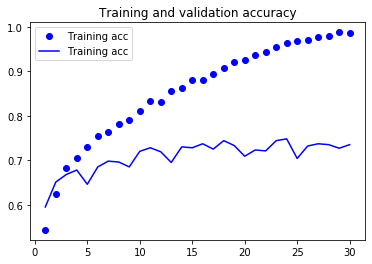

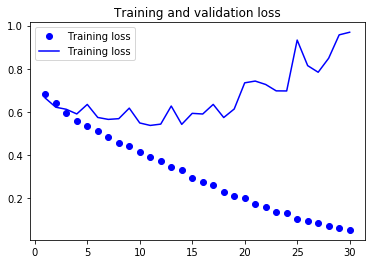

In [10]:
acc = history.history['binary_accuracy']
loss = history.history['loss']

val_acc = history.history['val_binary_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Training acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Training loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Evaluate the model

In [11]:
test_dir = os.path.join(base_dir, 'test')
test_datagen = image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150, 150),
                                                  batch_size=20,
                                                  class_mode='binary')

test_loss, test_acc = model.evaluate_generator(generator=test_generator, verbose=1)
print(f'test loss : {test_loss:.4f}')
print(f'test acc  : {test_acc:.4f}')

Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
50/50 [==============================] - 11s 220ms/step - loss: 0.9359 - binary_accuracy: 0.7300
test loss : 0.9359
test acc  : 0.7300
